In [1]:
import pathlib
import random

import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

import os
import matplotlib.pyplot as plt

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [31]:
checkpoint_path = 'training/'
imgroot_path = 'picture/all'
num_train = 2500
num_val = 0
batch_size = 32
epochs = 4
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [32]:
def load_image_label(path, label):
    image_raw = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_raw, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image /= 255.0
    return image, label

In [33]:
def load_image(path):
    image_raw = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_raw, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image /= 255.0
    return image

In [34]:
def plot_image(image):
    plt.figure(1)
    plt.imshow(image)
    plt.grid(False)
    plt.show()

In [35]:
data_path = pathlib.Path(imgroot_path)
all_image_paths = list(data_path.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths if str(path).endswith(".jpg")]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
label_names = sorted(item.name for item in data_path.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index, name in enumerate(label_names))
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]

print(image_count)
num_val = image_count - num_train

3076


In [36]:
train_image_paths = all_image_paths[:num_train]
val_image_paths = all_image_paths[num_train:]

train_image_labels = all_image_labels[:num_train]
val_image_labels = all_image_labels[num_train:]

In [37]:
train_path_image_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_labels))
val_path_image_ds = tf.data.Dataset.from_tensor_slices((val_image_paths, val_image_labels))

train_image_label_ds = train_path_image_ds.map(load_image_label)
val_image_label_ds = val_path_image_ds.map(load_image_label)

train_image_label_ds

<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int32)>

In [38]:
train_image_label_ds = train_image_label_ds.shuffle(buffer_size=image_count).repeat().batch(batch_size)
train_image_label_ds = train_image_label_ds.prefetch(buffer_size=AUTOTUNE)

val_image_label_ds = val_image_label_ds.shuffle(buffer_size=image_count).repeat().batch(batch_size)
val_image_label_ds = val_image_label_ds.prefetch(buffer_size=AUTOTUNE)

In [39]:
def create_model():
    model_url = "https://hub.tensorflow.google.cn/google/tf2-preview/mobilenet_v2/feature_vector/2"
    # model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_075_96/feature_vector/4"
    mobile_net = hub.KerasLayer(model_url, input_shape=(224,224,3))
    mobile_net.trainable = False

    # mobile_net = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), 
    #                                                include_top=False, 
    #                                                weights='imagenet')
    # mobile_net.trainable=False

    model = models.Sequential([
        mobile_net,
        # layers.GlobalAveragePooling2D(),
        layers.Dense(8, activation = 'softmax')
        # layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        # layers.MaxPooling2D(),
        # layers.Dropout(0.2),
        # layers.Conv2D(32, 3, padding='same', activation='relu'),
        # layers.MaxPooling2D(),
        # layers.Conv2D(64, 3, padding='same', activation='relu'),
        # layers.MaxPooling2D(),
        # layers.Dropout(0.2),
        # layers.Flatten(),
        # layers.Dense(512, activation='relu'),
        # layers.Dense(16, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [40]:
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 10248     
Total params: 2,268,232
Trainable params: 10,248
Non-trainable params: 2,257,984
_________________________________________________________________


In [41]:
model_log = model.fit(train_image_label_ds,
                      epochs=epochs,
                      steps_per_epoch=num_train,
                      validation_data=val_image_label_ds,
                      validation_steps=num_val)

Train for 2500 steps, validate for 576 steps
Epoch 1/4
2500/2500 [==============================] - 1561s 624ms/step - loss: 0.0222 - accuracy: 0.9954 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 2/4
2500/2500 [==============================] - 1468s 587ms/step - loss: 3.0825e-04 - accuracy: 1.0000 - val_loss: 5.9517e-04 - val_accuracy: 1.0000
Epoch 3/4
2500/2500 [==============================] - 1481s 592ms/step - loss: 7.2555e-05 - accuracy: 1.0000 - val_loss: 2.6807e-04 - val_accuracy: 1.0000
Epoch 4/4
2500/2500 [==============================] - 1419s 568ms/step - loss: 2.0124e-05 - accuracy: 1.0000 - val_loss: 1.2679e-04 - val_accuracy: 1.0000


In [42]:
model.save('training_res/model_mobilenetv2_2', save_format="tf")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: training_res/model_mobilenetv2_2/assets
INFO:tensorflow:Assets written to: training_res/model_mobilenetv2_2/assets


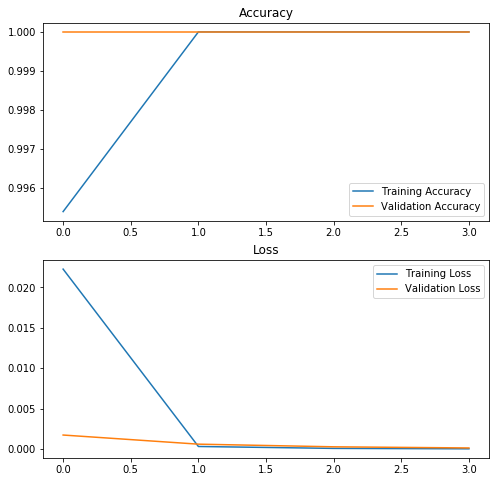

In [43]:
acc = model_log.history['accuracy']
val_acc = model_log.history['val_accuracy']

loss = model_log.history['loss']
val_loss = model_log.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.savefig('pic_A&L.jpg')
plt.show()

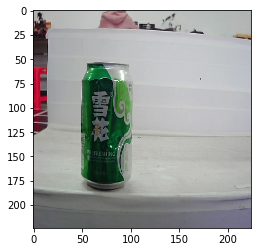

In [44]:
test_img_path = 'picture/test/500.jpg'

test_img = load_image(test_img_path)
plot_image(test_img)

In [45]:
test_img = np.reshape(test_img, (1, IMG_HEIGHT, IMG_WIDTH, 3))
pre = model.predict(test_img)
pre

array([[1.74226031e-07, 2.03948893e-08, 1.07039057e-07, 2.00301180e-08,
        9.25146892e-08, 1.00290656e-08, 1.43767735e-08, 9.99999642e-01]],
      dtype=float32)

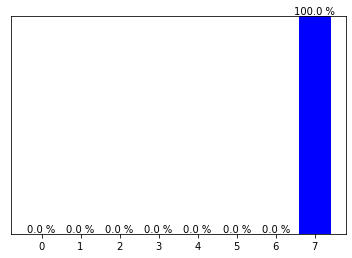

In [47]:
def plot_pre(pre):
    plt.grid(False)
    plt.xticks(range(len(pre)))
    plt.yticks([])
    thisplot = plt.bar(range(len(pre)), pre, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(pre)
    thisplot[predicted_label].set_color('blue')
    for i in range(len(pre)):
        plt.text(i, pre[i], '%.1f %%' % (pre[i]*100), ha='center', va='bottom')

    plt.figure(1)
    plt.show()

plot_pre(pre[0])